# 門診預約時間的問題

## 問題一: 掛號系統要依據哪種演算法來預約每個號碼的就診時間 ?
## 問題二: 病人根據這個就診時間是否會等很久? 
## 問題三: 根據現行的報到時間規則, 有沒有問題 ?

In [16]:
import pandas as pd 
import plotly.plotly as py
import cufflinks as cf
import re
import matplotlib.pyplot as plt 
#import matplotlib
import numpy as np
import warnings
from datetime import datetime, timedelta
from IPython.display import Image

%matplotlib inline
cf.go_offline()
#matplotlib.rcParams['font.family'] = ["SimHei"]
plt.rcParams["font.family"] = "SimHei"
pd.set_option('display.max_columns', 100)

warnings.filterwarnings('ignore')


# OPD.csv 為按號碼報到  OPD2.csv 為先到先看
df = pd.read_csv('data/OPD.csv',sep='\t')
#df = pd.read_csv('data/OPD2.csv',sep='\t')


df.就診日期 = df.就診日期.astype(str)  
df['就診日期2'] = pd.to_datetime(df.就診日期,infer_datetime_format=True, format='%Y%m%d' )

df['時間'] = pd.to_datetime(df.時間.astype(str) ,infer_datetime_format=True, format='%Y%m%d%H%M%S') 

print ( df.dtypes )
print (df.動作.unique())
df.head(10)

就診日期             object
午別               object
看診序號              int64
動作               object
時間       datetime64[ns]
等候時間              int64
就診日期2    datetime64[ns]
dtype: object
['一般報到 : 健保卡' '一般叫號' '過號報到 : 健保卡' '過號叫號' '指定叫號' '檢查報到 : 健保卡' '檢查叫號'
 '過號報到 : 手動' '敬老報到 : 健保卡' '敬老叫號' '一般報到 : 手動' '檢查報到 : 手動']


,就診日期,午別,看診序號,動作,時間,等候時間,就診日期2
0,20160701,下午,1,一般報到 : 健保卡,2016-07-01 13:56:29,0,2016-07-01
1,20160701,下午,1,一般叫號,2016-07-01 14:10:54,14,2016-07-01
2,20160701,下午,2,一般報到 : 健保卡,2016-07-01 14:02:09,0,2016-07-01
3,20160701,下午,2,一般叫號,2016-07-01 14:14:54,12,2016-07-01
4,20160701,下午,3,過號報到 : 健保卡,2016-07-01 14:24:45,0,2016-07-01
5,20160701,下午,3,過號叫號,2016-07-01 14:30:52,5,2016-07-01
6,20160701,下午,5,一般報到 : 健保卡,2016-07-01 14:22:20,0,2016-07-01
7,20160701,下午,5,一般叫號,2016-07-01 14:24:04,1,2016-07-01
8,20160701,下午,6,過號報到 : 健保卡,2016-07-01 15:14:08,0,2016-07-01
9,20160701,下午,6,過號叫號,2016-07-01 15:16:04,1,2016-07-01


# 可能的 Features 

* 就診日期 : 日期是否有差別 ?	
* 午別 : 上下午是否有差別 ?
* 看診序號	: 早點掛號是否有差別 ?
* 動作 : 報到種類 (遲到) 是否有差別 ?

# 缺乏的 Features 
* 沒有單次看診長度

In [2]:
# 報到的種類 : Possible futher investigation features 
df.groupby('動作').size().reset_index()

,動作,0
0,一般叫號,170
1,一般報到 : 健保卡,204
2,一般報到 : 手動,10
3,指定叫號,19
4,敬老叫號,7
5,敬老報到 : 健保卡,7
6,檢查叫號,31
7,檢查報到 : 健保卡,28
8,檢查報到 : 手動,12
9,過號叫號,124


## 重新計算精確等候時間到秒

In [3]:
# 報到時間應該是 同一看診序號 最早的時間 , minimum(時間)
df2 = df.groupby(['就診日期','午別','看診序號'])['時間'].min().reset_index()
df3 = pd.merge(df2,df, on=['就診日期','午別','看診序號'])

# 重新計算 精確等候時間
df3['等候時間2'] = df3.時間_y - df3.時間_x
df3.head(10)



,就診日期,午別,看診序號,時間_x,動作,時間_y,等候時間,等候時間2
0,20160701,下午,1,2016-07-01 13:56:29,一般報到 : 健保卡,2016-07-01 13:56:29,0,00:00:00
1,20160701,下午,1,2016-07-01 13:56:29,一般叫號,2016-07-01 14:10:54,14,00:14:25
2,20160701,下午,2,2016-07-01 14:02:09,一般報到 : 健保卡,2016-07-01 14:02:09,0,00:00:00
3,20160701,下午,2,2016-07-01 14:02:09,一般叫號,2016-07-01 14:14:54,12,00:12:45
4,20160701,下午,3,2016-07-01 14:24:45,過號報到 : 健保卡,2016-07-01 14:24:45,0,00:00:00
5,20160701,下午,3,2016-07-01 14:24:45,過號叫號,2016-07-01 14:30:52,5,00:06:07
6,20160701,下午,5,2016-07-01 14:22:20,一般報到 : 健保卡,2016-07-01 14:22:20,0,00:00:00
7,20160701,下午,5,2016-07-01 14:22:20,一般叫號,2016-07-01 14:24:04,1,00:01:44
8,20160701,下午,6,2016-07-01 15:14:08,過號報到 : 健保卡,2016-07-01 15:14:08,0,00:00:00
9,20160701,下午,6,2016-07-01 15:14:08,過號叫號,2016-07-01 15:16:04,1,00:01:56


# 分析1 : 報到種類和等候時間之關係

,Mean,SD
動作,,
一般叫號,26.347059,23.197190
指定叫號,9.736842,12.600009
敬老叫號,19.714286,9.707631
檢查叫號,15.806452,13.998617
過號叫號,15.193548,13.043191


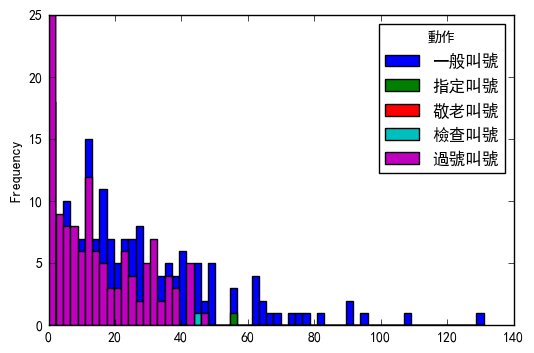

In [4]:
df3[~df3.動作.str.contains('報到')].groupby('動作').size().reset_index().iplot(kind ='pie',labels = '動作', values= 0)

df3_2 = df3[~df3.動作.str.contains('報到')].pivot(columns='動作', values='等候時間')
df3_2.iplot(kind = 'histogram'
            ,barmode='overlay'
            #,bins = 60
            ,xTitle='等候時間'
            ,yTitle="病人數"
            #,shape=(5, 1)
            #,subplots=True
            #,histnorm = 'probability'
           )
df3_2.plot(kind ='hist',bins = 60)

df3_stat = pd.DataFrame([df3_2.mean(),df3_2.std()]).T
df3_stat.columns = ['Mean', 'SD']
df3_stat

# Q: 不同叫號方式等待之時間是否不同 ? 可能的解釋為何 ?

# 分析2: 看診序號 和等待時間的關係

In [5]:
df3_se = df3[['看診序號', '等候時間']]
df3_se = df3_se [ df3_se.等候時間 != 0]
df3_se.看診序號.astype('str')
df3_se.iplot(kind = 'scatter', mode='markers', x= '看診序號', y = '等候時間', title='看診序號 和等待時間的關係', xTitle='看診序號',yTitle='等待時間' )

# 列出等待時間最少的號碼前5名
print ('列出等待時間最少的號碼前5名')
df3_se.groupby('看診序號').mean().sort_values(by ='等候時間',ascending = True).head(5)
#df3_se.groupby('看診序號').size().sort_values(ascending = True).head(5)

列出等待時間最少的號碼前5名


,等候時間
看診序號,
17,2.000000
8,7.625000
15,10.857143
5,11.466667
7,12.444444


## Q : 號碼前面等的比較短 號碼後面等的比較長? 有沒有哪些特別號碼等待時間比較少 ? 怎麼解釋 ?

# 分析3 : 上下午等待時間是否不同 ?

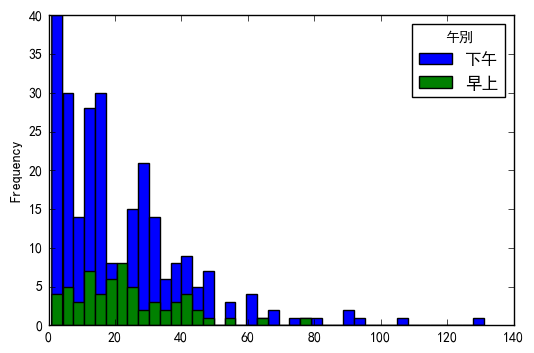

In [6]:
df[(df.午別.str.contains('上')) & (df.等候時間 != 0) ] ['等候時間'].iplot(kind = 'hist'
                                                               , bins=40
                                                               ,title='上午診'
                                                               ,xTitle='等候時間'
                                                               ,yTitle="病人數"
                                                              )

df[df.等候時間 != 0].pivot(columns='午別', values='等候時間').iplot(kind='hist'
                                                          ,bins=30
                                                          ,barmode='stack'
                                                          #,subplots=True
                                                          #,shape=(2, 1)
                                                          ,xTitle = '等候時間'
                                                          ,yTitle = 'probability'
                                                          ,histnorm = 'probability'
                                                         )
df[df.等候時間 != 0].pivot(columns='午別', values='等候時間').plot(kind='hist',bins=40)

# 分析4: 報到時間點 的 等待時間 是否有關 ? 
* 整理 dataframe , '時間_x' 是報到時間, '時間_y' 是看診時間
*  統一改用 上午9:00後 幾分鐘報到 ; 下午 14:00 後 幾分鐘報到 

In [7]:

df4 = df3[df3.等候時間2 >  timedelta(0)]
df4['報到時間2'] = np.where(df4['午別'].str.contains('下')
                        ,df4.時間_x - pd.to_datetime(df4.就診日期,infer_datetime_format=True, format='%Y%m%d') - pd.to_timedelta('14:00:00') 
                        ,df4.時間_x - pd.to_datetime(df4.就診日期,infer_datetime_format=True, format='%Y%m%d') - pd.to_timedelta('09:00:00')
                        )

df4['報到時間3'] = df4['報到時間2'].apply(lambda x: x/ np.timedelta64(1, 'm'))
df4.head(10)

,就診日期,午別,看診序號,時間_x,動作,時間_y,等候時間,等候時間2,報到時間2,報到時間3
1,20160701,下午,1,2016-07-01 13:56:29,一般叫號,2016-07-01 14:10:54,14,00:14:25,-1 days +23:56:29,-3.516667
3,20160701,下午,2,2016-07-01 14:02:09,一般叫號,2016-07-01 14:14:54,12,00:12:45,00:02:09,2.150000
5,20160701,下午,3,2016-07-01 14:24:45,過號叫號,2016-07-01 14:30:52,5,00:06:07,00:24:45,24.750000
7,20160701,下午,5,2016-07-01 14:22:20,一般叫號,2016-07-01 14:24:04,1,00:01:44,00:22:20,22.333333
9,20160701,下午,6,2016-07-01 15:14:08,過號叫號,2016-07-01 15:16:04,1,00:01:56,01:14:08,74.133333
11,20160701,下午,7,2016-07-01 15:01:13,過號叫號,2016-07-01 15:01:25,0,00:00:12,01:01:13,61.216667
13,20160701,下午,9,2016-07-01 15:18:11,過號叫號,2016-07-01 15:22:40,4,00:04:29,01:18:11,78.183333
15,20160701,下午,10,2016-07-01 14:14:57,指定叫號,2016-07-01 14:20:59,6,00:06:02,00:14:57,14.950000
18,20160701,下午,13,2016-07-01 14:25:58,一般叫號,2016-07-01 14:43:46,17,00:17:48,00:25:58,25.966667
20,20160701,下午,14,2016-07-01 14:46:45,一般叫號,2016-07-01 14:52:46,5,00:06:01,00:46:45,46.750000


In [8]:
# Seperate AM and PM dataset

PM = df4[df4.午別.str.contains('下') ] [['報到時間3','等候時間']] 
AM = df4[df4.午別.str.contains('上') ] [['報到時間3','等候時間']] 
AM.to_csv('data/OPD2_AM.csv', index=None)
PM.to_csv('data/OPD2_PM.csv', index=None)

print (len(AM), '位患者')


74 位患者


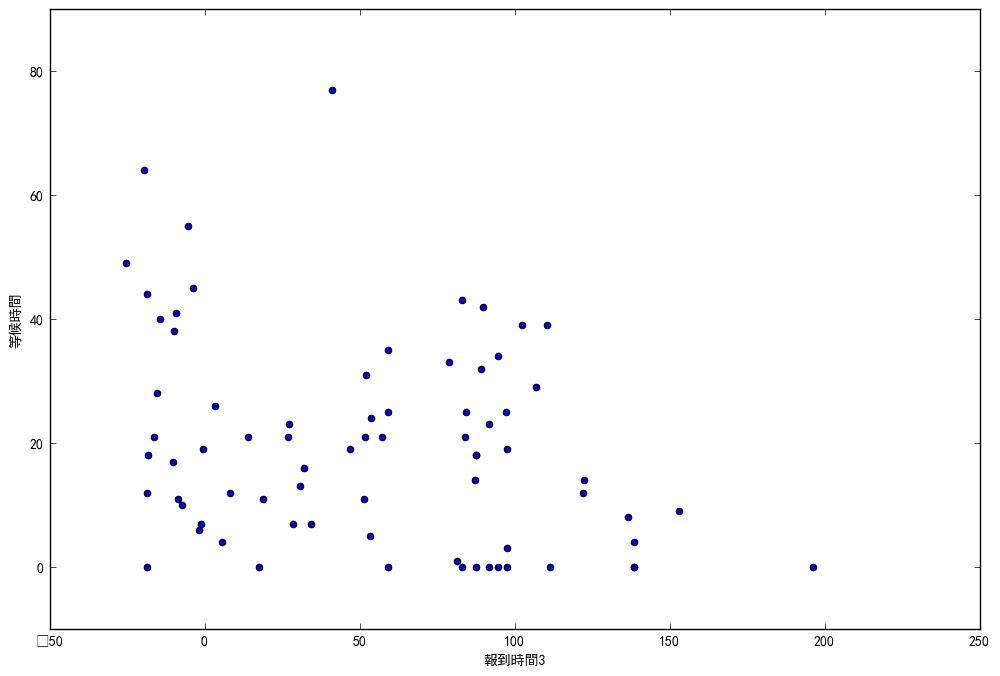

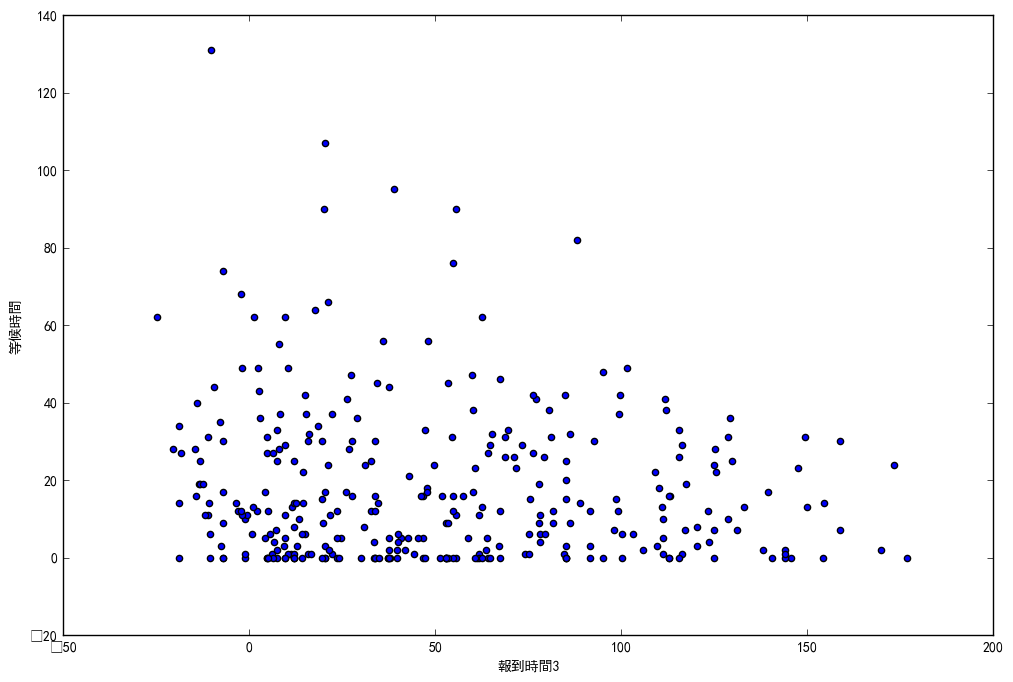

In [9]:
AM.iplot(kind='scatter', mode='markers', x='報到時間3', y='等候時間',title='上午 共' + str(len(AM)) +'位患者', xTitle='插卡時間(9:00後 分鐘)', yTitle='等候時間(分鐘)', online=False)
PM.iplot(kind='scatter', mode='markers', x='報到時間3', y='等候時間',title='下午 共' + str(len(PM)) +'位患者', xTitle='插卡時間(14:00後 分鐘)', yTitle='等候時間(分鐘)', online=False)

try: 
    AM.plot.scatter('報到時間3','等候時間', figsize= (12,8))
    PM.plot.scatter('報到時間3','等候時間', figsize= (12,8))
    plt.xlabel('報到時間3')
    plt.ylabel('等候時間')
except TypeError:
    pass

# 分析5 : 是不是可以用 Kernel density 來 模擬 分佈 並預測 ?
## 用 KDE 
* http://scikit-learn.org/stable/modules/density.html
## 2 variable KDE estimation
* http://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#example-neighbors-plot-kde-1d-py

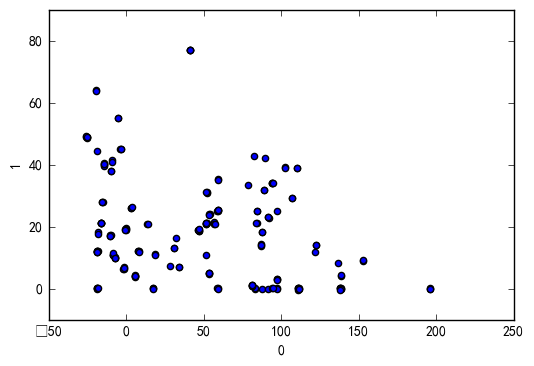

In [10]:
from sklearn.neighbors.kde import KernelDensity
X = np.array(AM)
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
kde.score_samples(X)


# 畫看看 kde fit 後, sample 大概長怎樣
pd.DataFrame( kde.sample(200)) .plot.scatter(0,1)

# KRR kernel ridge regression
* http://scikit-learn.org/stable/auto_examples/plot_kernel_ridge_regression.html

/Users/tom/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/Users/tom/anaconda/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20



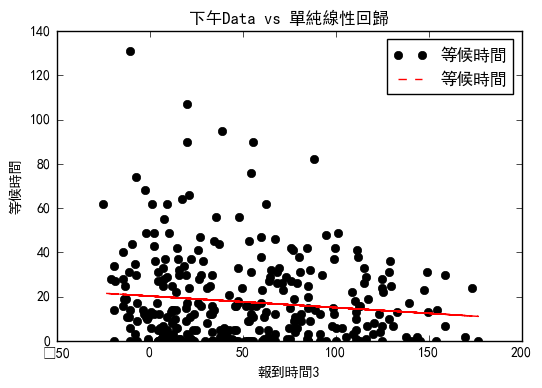

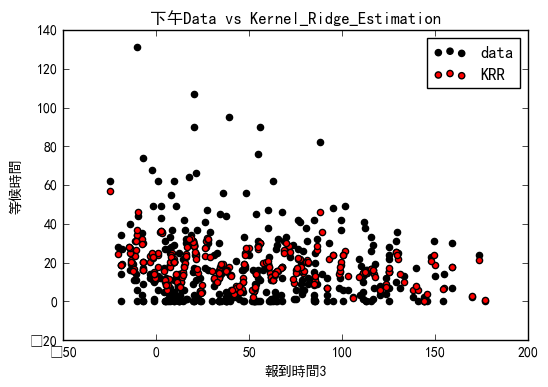

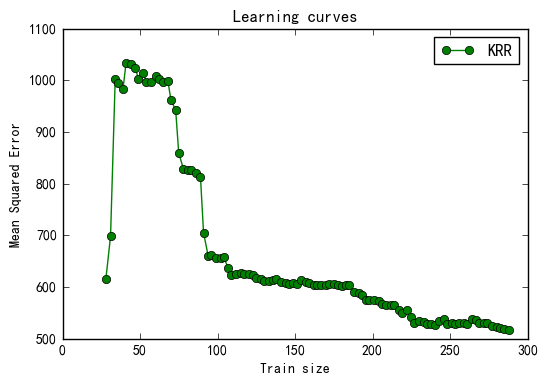

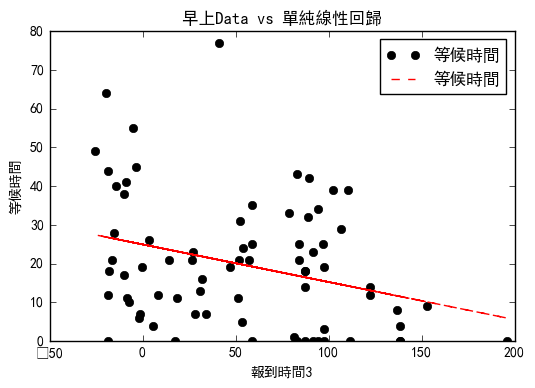

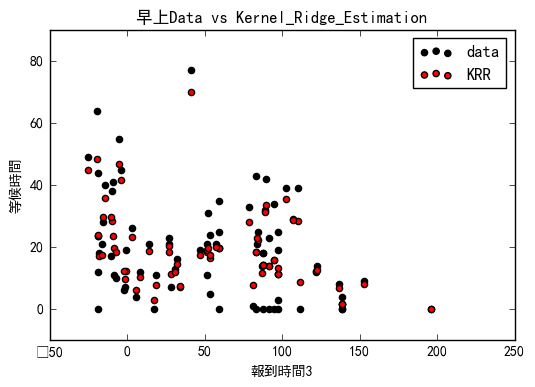

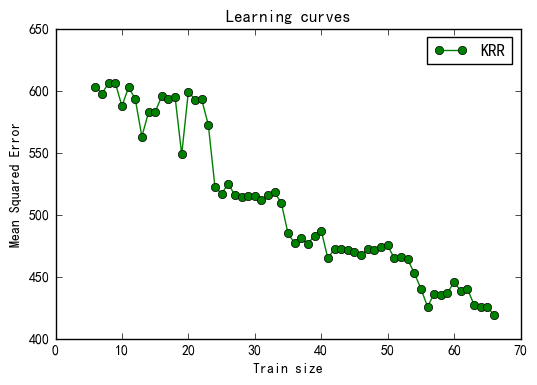

In [11]:
from sklearn.learning_curve import learning_curve
from sklearn.kernel_ridge import KernelRidge

for x in df4.午別.unique():

    # fit_fn is now a function which takes in x and returns an estimate for y 單純線性回歸
    plt.figure()    
    X1 = df4[df4.午別.str.contains(x)].報到時間3
    y1 = df4[df4.午別.str.contains(x)].等候時間
    fit = np.polyfit(X1,y1,1)
    fit_fn = np.poly1d(fit)     
    plt.plot(X1,y1, 'ko', X1, fit_fn(X1), '--r')    
    plt.xlabel('報到時間3')
    plt.ylabel('等候時間')
    plt.title( x + 'Data vs 單純線性回歸')
    plt.legend()
    plt.show()

    # Prepare the data 
    X = np.asarray(df4[df4.午別.str.contains(x)].報到時間3).reshape(-1,1)
    y = np.asarray(df4[df4.午別.str.contains(x)].等候時間)

    # Fit the data and predict 
    kr = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.1)
    kr.fit(X, y)
    y_kr = kr.predict(X)

    # Visuaization of the results
    plt.scatter(X, y, c='k', label='data', zorder=1)
    plt.scatter(X, y_kr, c='r',label='KRR' )
    plt.xlabel('報到時間3')
    plt.ylabel('等候時間')
    plt.title(x + 'Data vs Kernel_Ridge_Estimation')
    plt.legend()

    pd.DataFrame(X,y)
    # Visualize learning curves
    plt.figure()

    train_sizes_abs, train_scores_kr, test_scores_kr = \
        learning_curve(kr, X, y, train_sizes=np.linspace(0.1, 1, 100),
                       scoring="neg_mean_squared_error", cv=10)

    plt.plot(train_sizes_abs, -test_scores_kr.mean(1), 'o-', color="g",
             label="KRR")
    plt.xlabel("Train size")
    plt.ylabel("Mean Squared Error")
    plt.title('Learning curves')
    plt.legend(loc="best")

    plt.show()
    
    
    

In [12]:
?np.where